In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from model import OrthogonalAutoEncoder
from training_utils import TrainingModel, create_grouped_bar_plot
from gradients import get_integrated_gradients, get_integrated_gradients_mc

In [2]:
# AI4I (data from https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset)
# only keeping columns: Air_temperature, Process_temperature, Rotational_speed, Torque, Tool_wear, y
df = pd.read_csv("/Users/dcac/Data/ai4i/ai4i2020_reduced.csv").iloc[:1000, 3:]
df_train = df[df["y"] == 0].drop(["y"], axis=1)  # clean training data to fit the model
df_test = df[df["y"] == 1].drop(["y"], axis=1)

In [3]:
df.columns

Index(['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque',
       'Tool_wear', 'y'],
      dtype='object')

In [4]:
# Scaling data
scaler = StandardScaler()
x1 = torch.Tensor(pd.DataFrame(scaler.fit_transform(df_train)).values)
x2 = torch.Tensor(pd.DataFrame(scaler.transform(df_train)).values)

In [5]:
# Initiating model
model = OrthogonalAutoEncoder(encoding_layers=[5, 5], activation_function=nn.ReLU(), dropout=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)
sum(p.numel() for p in model.parameters() if p.requires_grad)  # number of parameters

OrthogonalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU()
    (3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): ReLU()
    (3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


80

In [6]:
# Training model (validation loss is lower because of dropout)
train = TrainingModel(penalty=0.1, learning_rate=0.001, batch_size=20, val_size=0.20, verbose=True)
train_loader, valid_loader = train.create_datasets(train_data=x1)
trained_model, losses = train.train_model(model, patience=10, n_epochs=1000)

[   1/1000] train_loss: 13.814720 valid_loss: 17.968778
Validation loss decreased (inf --> 17.968778).  Saving model ...
[   2/1000] train_loss: 10.527803 valid_loss: 13.196940
Validation loss decreased (17.968778 --> 13.196940).  Saving model ...
[   3/1000] train_loss: 8.513852 valid_loss: 19.409148
EarlyStopping counter: 1 out of 10
[   4/1000] train_loss: 7.094853 valid_loss: 15.626651
EarlyStopping counter: 2 out of 10
[   5/1000] train_loss: 5.963108 valid_loss: 8.960754
Validation loss decreased (13.196940 --> 8.960754).  Saving model ...
[   6/1000] train_loss: 5.113525 valid_loss: 7.425166
Validation loss decreased (8.960754 --> 7.425166).  Saving model ...
[   7/1000] train_loss: 4.290894 valid_loss: 9.108599
EarlyStopping counter: 1 out of 10
[   8/1000] train_loss: 3.732281 valid_loss: 4.842178
Validation loss decreased (7.425166 --> 4.842178).  Saving model ...
[   9/1000] train_loss: 3.270917 valid_loss: 5.141266
EarlyStopping counter: 1 out of 10
[  10/1000] train_loss: 

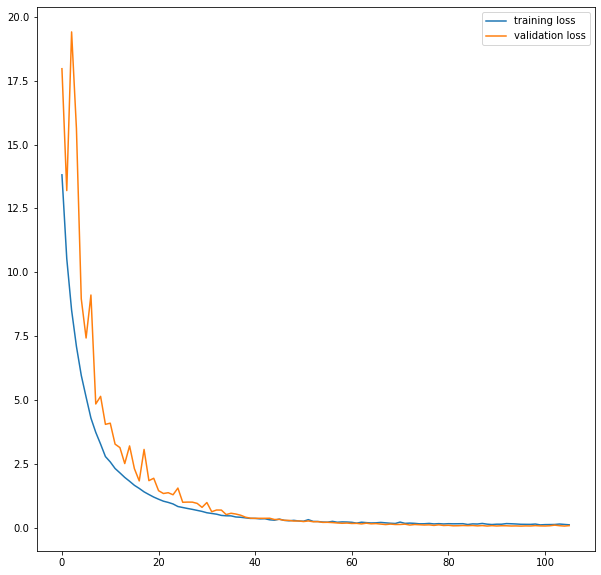

In [7]:
# Plot losses
plt.figure(figsize=(10, 10))
plt.plot(losses["train"], label="training loss")
plt.plot(losses["val"], label="validation loss")
plt.legend()
plt.show()

In [8]:
# Saving trained model
torch.save(trained_model, "orthogonal_autoencoder.pt")

In [9]:
# Computing integrated gradients of the encoder network
base = x1.mean(axis=0)
example = x2[0]
int_grads_tr, _ = get_integrated_gradients(model=trained_model, inp=example, baseline=base, steps=20)
int_grads_mc, _ = get_integrated_gradients_mc(model=trained_model, inp=example, baseline=base, samples=100)

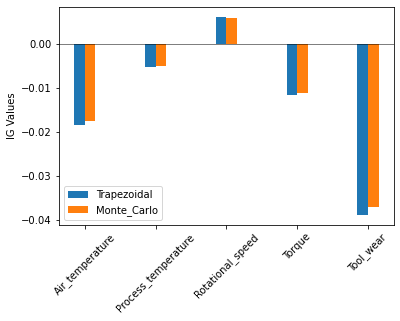

In [10]:
# Plotting integrated gradients
create_grouped_bar_plot(df_train.columns, Trapezoidal=int_grads_tr, Monte_Carlo=int_grads_mc)